# Modelos Baseline con todas las variables

## Librerías

In [38]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import confusion_matrix, classification_report
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler,LabelEncoder
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.sparse import hstack
from sklearn.metrics import accuracy_score, log_loss, confusion_matrix, classification_report

In [39]:
df=pd.read_csv('/Users/isaromobru/Desktop/FakeNews 10.57.24/proyecto_machine_learning_Fake_News/data/processed/archivo.csv')

In [40]:
le = LabelEncoder()
df['subject_encoded'] = le.fit_transform(df['subject_grouped'])


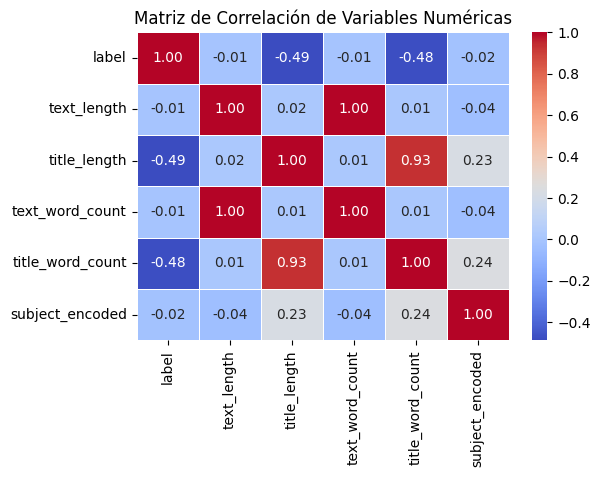

In [5]:
# Seleccionar solo las columnas numéricas
df_numeric = df.select_dtypes(include=['number'])

# Calcular la matriz de correlación
correlation_matrix = df_numeric.corr()

# Graficar el mapa de calor de correlación


plt.figure(figsize=(6, 4))
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", fmt=".2f", linewidths=0.5)
plt.title("Matriz de Correlación de Variables Numéricas")
plt.show()


📊 Análisis de la Matriz de Correlación
Aquí están las observaciones clave de tu gráfico:

"subject_encoded" tiene una correlación baja con "label" (-0.02)
Esto indica que la variable "subject_grouped" (politics vs general) no influye mucho en si una noticia es falsa o verdadera.
Puede que no sea una variable crucial para el modelo, pero podríamos probar su impacto.
"title_length" y "title_word_count" tienen una correlación fuerte con "label" (-0.49 y -0.48)
Esto significa que el tamaño del título de la noticia es un predictor fuerte para determinar si es falsa o verdadera.
Noticias falsas tienden a tener títulos más cortos o con menos palabras.
"text_length" y "text_word_count" tienen correlaciones muy bajas con "label"
Parecen no ser tan importantes para predecir si la noticia es falsa o verdadera.

In [41]:
from scipy.sparse import csr_matrix, hstack
# Asegurar que no haya valores nulos
df['text'] = df['text'].fillna("")
df['title'] = df['title'].fillna("")

# Vectorización con TF-IDF (manteniendo sparse matrices)
tfidf_text = TfidfVectorizer(max_features=5000, stop_words='english')
tfidf_title = TfidfVectorizer(max_features=1000, stop_words='english')

X_text = tfidf_text.fit_transform(df['text'])
X_title = tfidf_title.fit_transform(df['title'])

# Variables numéricas (convertidas a matriz dispersa)
X_other_features = csr_matrix(df[['subject_encoded', 'title_length', 'title_word_count']].values)

# Concatenar matrices dispersas sin convertirlas a DataFrame
X_final = hstack([X_other_features, X_text, X_title])

# Variable objetivo
y = df['label']

## División variables

In [42]:

# Dividir en Train/Test
X_train, X_test, y_train, y_test = train_test_split(X_final, y, test_size=0.2, random_state=42, stratify=y)

# Mostrar tamaños de los conjuntos
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((35751, 6003), (8938, 6003), (35751,), (8938,))

In [21]:
print(df['text_length'].isna().sum())


0


In [23]:
print(df['title_word_count'].isna().sum())


0


## Regresión Logística

In [8]:

# Entrenar el modelo de Regresión Logística
logreg_model = LogisticRegression(max_iter=500, solver='liblinear')  # Solver optimizado para datos grandes
logreg_model.fit(X_train, y_train)

# Predicciones en el conjunto de prueba
y_pred_logreg = logreg_model.predict(X_test)

# Evaluar el modelo
conf_matrix_logreg = confusion_matrix(y_test, y_pred_logreg)
class_report_logreg = classification_report(y_test, y_pred_logreg)

# Mostrar los resultados
conf_matrix_logreg, class_report_logreg

(array([[4636,   60],
        [  17, 4225]]),
 '              precision    recall  f1-score   support\n\n           0       1.00      0.99      0.99      4696\n           1       0.99      1.00      0.99      4242\n\n    accuracy                           0.99      8938\n   macro avg       0.99      0.99      0.99      8938\nweighted avg       0.99      0.99      0.99      8938\n')

Interpretación:

4636 → Verdaderos negativos (clase 0 correctamente clasificada)
60 → Falsos positivos (clase 0 mal clasificada como clase 1)
17 → Falsos negativos (clase 1 mal clasificada como clase 0)
4225 → Verdaderos positivos (clase 1 correctamente clasificada)
📌 Conclusiones:

Solo 60 instancias de la clase 0 fueron clasificadas erróneamente como 1.
Solo 17 instancias de la clase 1 fueron clasificadas erróneamente como 0.
La clasificación es extremadamente precisa con muy pocos errores.

📌 Explicación de las métricas:

Precisión (Precision): De todas las predicciones positivas, cuántas realmente lo son.
Clase 0: 1.00 → Casi todas las predicciones de la clase 0 son correctas.
Clase 1: 0.99 → Muy pocas veces se confunde otra clase con la clase 1.

Exhaustividad (Recall): De todas las instancias reales de la clase, cuántas fueron correctamente identificadas.
Clase 0: 0.99 → Un 99% de los casos de clase 0 se identifican correctamente.
Clase 1: 1.00 → Casi ningún caso de clase 1 se escapa.

F1-Score: Media armónica entre precisión y recall, mide el equilibrio entre ambos.
Ambas clases tienen 0.99, lo que indica un excelente balance entre precisión y recall.

Exactitud (Accuracy):
99% de las predicciones fueron correctas (aciertos totales sobre el total de datos).

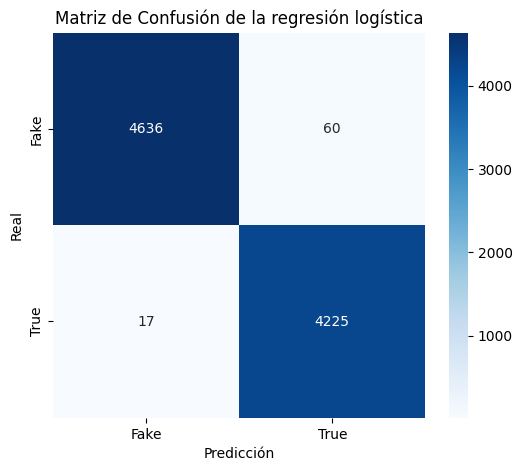

In [41]:
# Definir valores de la matriz de confusión
cm = np.array([[4636, 60],
               [17, 4225]])

# Etiquetas de las clases
labels = ['Fake', 'True']

# Graficar la matriz de confusión
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicción')
plt.ylabel('Real')
plt.title('Matriz de Confusión de la regresión logística')
plt.show();


Esta matriz de confusión nos indica que nuestro modelo clasifica 4589 fakes cuando son fake, 4225 True cuando son True. 
Por otro lado, se equivoca clasificando Fake cuando es True 65 y True cuando es Fake 59, son valores bastante bajos teniendo en cuenta el tamaño de la muestra 

la regresión logística tiene una precisión muy alta de un 0,99, por lo que voy a comprobar si tiene overfitting

In [42]:
# 5. Evaluación del modelo
# Predicciones
y_train_pred_proba = logreg_model.predict_proba(X_train)[:, 1]  # Probabilidad de la clase 1 en entrenamiento
y_test_pred_proba = logreg_model.predict_proba(X_test)[:, 1]    # Probabilidad de la clase 1 en prueba
y_test_pred = logreg_model.predict(X_test)

# Cálculo de log loss
log_loss_train = log_loss(y_train, y_train_pred_proba)
log_loss_test = log_loss(y_test, y_test_pred_proba)

log_loss_train, log_loss_test

(0.041900519306624785, 0.04908235823590299)

Valores bajos de Log Loss indican un buen modelo: Valores cercanos a 0 significan que el modelo está prediciendo probabilidades muy precisas.
En este caso, los valores 0.0419 y 0.0491 son muy bajos, lo que indica que el modelo tiene una excelente calibración y confianza en sus predicciones

In [43]:
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression

# Aplicar Validación Cruzada (Usando 5 folds)
cv_scores = cross_val_score(logreg_model, X_other_features, y, cv=5, scoring='accuracy')

# Mostrar resultados
print(f"Scores por cada fold: {cv_scores}")
print(f"Precisión promedio: {cv_scores.mean():.4f}")
print(f"Desviación estándar: {cv_scores.std():.4f}")


Scores por cada fold: [0.59968673 0.63056612 0.77959275 0.53445961 0.6183283 ]
Precisión promedio: 0.6325
Desviación estándar: 0.0807


- Rango de resultados
El mejor fold alcanzó 77.96% de precisión.
El peor fold tuvo solo 53.45% de precisión.
Hay bastante variabilidad entre los folds, lo que indica que el modelo puede estar funcionando mejor en ciertos subconjuntos del conjunto de datos.
- Precisión promedio: 63.25%
Esto indica que, en promedio, el modelo tiene un rendimiento moderado, pero no óptimo.
- Desviación estándar: 0.0807 (8.07%)
Una desviación estándar alta sugiere que el modelo es inconsistente en distintos folds.
Es posible que el modelo tenga problemas con la variabilidad de los datos o que sea sensible a ciertos patrones.

📌 Conclusión

✅ El modelo tiene un desempeño aceptable (63.25% de precisión en promedio).
⚠️ Hay variabilidad entre los folds, lo que sugiere que la calidad de la predicción depende mucho de los datos en cada subconjunto.

## XG-Boost

In [9]:
from xgboost import XGBClassifier

xgb_model = XGBClassifier(
    eval_metric='logloss',   # Métrica de evaluación
    
    max_depth=6,             # Controla la complejidad del modelo
    learning_rate=0.1,       # Tasa de aprendizaje equilibrada
    n_estimators=300,        # Aumenta el número de árboles para mejorar el ajuste
    subsample=0.8,           # Reduce overfitting usando solo el 80% de los datos por árbol
    colsample_bytree=0.8,    # Usa el 80% de las características en cada árbol
    gamma=0.1,               # Ayuda a la regularización
    reg_lambda=1,            # Regularización L2 para evitar overfitting
    reg_alpha=0.1            # Regularización L1
)

# Entrenar el modelo
xgb_model.fit(X_train, y_train)

# Predicciones
y_pred_xgb = xgb_model.predict(X_test)

# Evaluar el modelo
conf_matrix = confusion_matrix(y_test, y_pred_xgb)
class_report = classification_report(y_test, y_pred_xgb, digits=4)

# Mostrar los resultados
conf_matrix, class_report


(array([[4690,    6],
        [   6, 4236]]),
 '              precision    recall  f1-score   support\n\n           0     0.9987    0.9987    0.9987      4696\n           1     0.9986    0.9986    0.9986      4242\n\n    accuracy                         0.9987      8938\n   macro avg     0.9987    0.9987    0.9987      8938\nweighted avg     0.9987    0.9987    0.9987      8938\n')

📌 Explicación de las métricas:

- Precisión (Precision):

    Para la clase 0: 99.87% de las veces que el modelo predice un 0, realmente lo es.
    
    Para la clase 1: 99.86% de las veces que predice un 1, acierta.
- Exhaustividad (Recall):

    Para la clase 0: Identificó correctamente 99.87% de los casos reales de clase 0.
    
    Para la clase 1: Identificó correctamente 99.86% de los casos reales de clase 1.
- F1-Score:
    0.9987 y 0.9986 indican un rendimiento casi perfecto en ambas clases.
- Exactitud (Accuracy):
    99.87% de precisión global sobre todo el dataset.

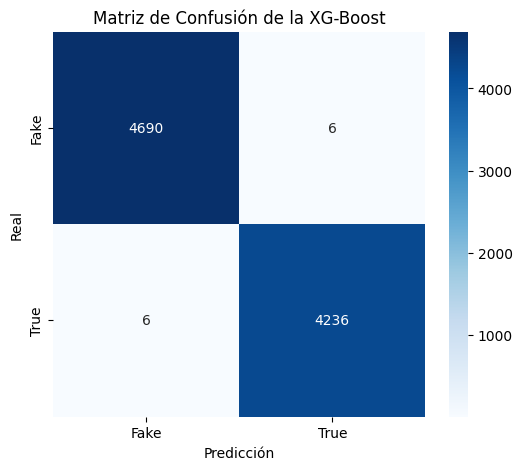

In [36]:
# Definir valores de la matriz de confusión
cm = np.array([[4690, 6],
               [6, 4236]])

# Etiquetas de las clases
labels = ['Fake', 'True']

# Graficar la matriz de confusión
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicción')
plt.ylabel('Real')
plt.title('Matriz de Confusión de la XG-Boost')
plt.show();



Interpretación:

- 4690 → Verdaderos negativos (clase 0 correctamente clasificada).
- 6 → Falsos positivos (clase 0 mal clasificada como clase 1).
- 6 → Falsos negativos (clase 1 mal clasificada como clase 0).
- 4236 → Verdaderos positivos (clase 1 correctamente clasificada).

📌 Conclusiones:
- Apenas 12 errores en 8938 muestras (6 falsas positivas y 6 falsas negativas).
- La clasificación es casi perfecta con solo 0.13% de error.


In [45]:
# Calcular las probabilidades predichas para calcular log loss
y_train_pred_probaxgb = xgb_model.predict_proba(X_train)[:, 1]  # Probabilidad de la clase 1 en entrenamiento
y_test_pred_probaxgb = xgb_model.predict_proba(X_test)[:, 1]    # Probabilidad de la clase 1 en prueba

# Calcular log loss en entrenamiento y prueba
log_loss_train = log_loss(y_train, y_train_pred_probaxgb)
log_loss_test = log_loss(y_test, y_test_pred_probaxgb)

# Mostrar los resultados
log_loss_train, log_loss_test


(0.00045481997332146035, 0.006478380075856221)



Valores extremadamente bajos de Log Loss

- Un log loss cercano a 0 indica que el modelo está generando predicciones de alta confianza y muy precisas.
En este caso:
    0.00045 en entrenamiento → Sugiere que el modelo ha aprendido casi a la perfección el conjunto de entrenamiento.
    0.00648 en prueba → Sigue siendo un valor muy bajo, lo que indica que el modelo mantiene su rendimiento en datos no vistos.
- Diferencia entre entrenamiento y prueba
Hay una diferencia muy pequeña entre ambos valores (≈0.006), lo cual es una muy buena señal.
Esto indica que el modelo no está sobreajustado, ya que el rendimiento en prueba sigue siendo muy alto.

In [46]:
# Ejecutar validación cruzada
cv_scores = cross_val_score(xgb_model, X_final, y, cv=5, scoring='accuracy')

# Mostrar los resultados
print(f"Precisión promedio: {cv_scores.mean():.4f}")
print(f"Desviación estándar: {cv_scores.std():.4f}")

Precisión promedio: 0.9964
Desviación estándar: 0.0014




- Precisión Promedio = 99.64%
    Esto indica que, en validación cruzada, el modelo mantiene un rendimiento consistentemente alto en diferentes subconjuntos de datos.
Es un resultado excelente, lo que confirma que el modelo tiene una capacidad de generalización muy fuerte.
- Desviación Estándar = 0.0014 (0.14%)
    Una desviación estándar tan baja indica que el modelo es muy estable en diferentes folds de validación cruzada.
    Significa que los resultados son consistentes sin variaciones significativas entre diferentes conjuntos de entrenamiento y prueba.



Un valor alto de desviación estándar indicaría que el modelo es sensible a los datos, pero en este caso, la variabilidad es mínima.

📌 Conclusiones

✅ El modelo XGBoost es extremadamente preciso (99.64%).

✅ Es altamente estable y consistente en diferentes folds de validación cruzada.

✅ No hay signos de sobreajuste, ya que los valores son constantes y el log loss también es bajo.



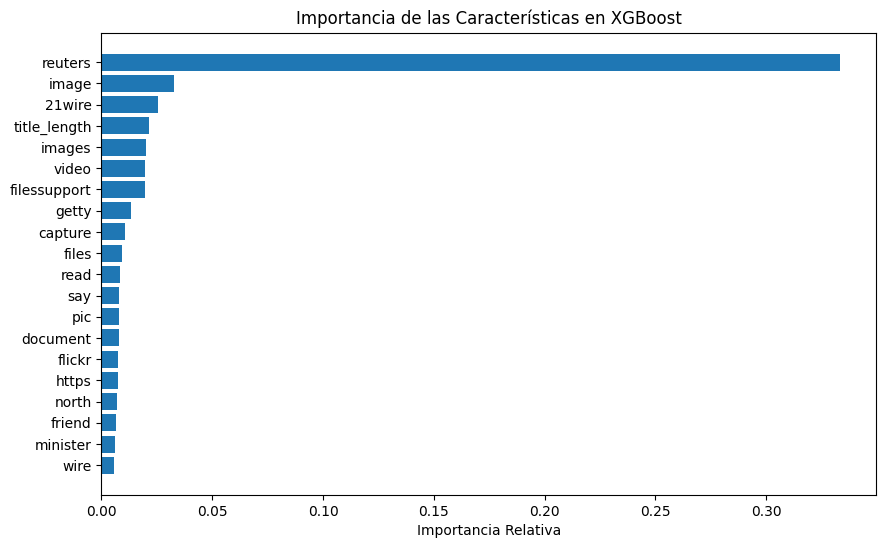

In [60]:
# Obtener importancia de características
importances_xgb = xgb_model.feature_importances_
sorted_idx_xgb = np.argsort(importances_xgb)[-20:]  # Tomar solo las 20 más importantes

# Graficar
plt.figure(figsize=(10, 6))
plt.barh(range(len(sorted_idx_xgb)), importances_xgb[sorted_idx_xgb], align='center')
plt.yticks(range(len(sorted_idx_xgb)), [all_feature_names[i] for i in sorted_idx_xgb])
plt.xlabel("Importancia Relativa")
plt.title("Importancia de las Características en XGBoost")
plt.show()

## Gradient boosting

In [43]:
from sklearn.ensemble import GradientBoostingClassifier

# Entrenar el modelo Gradient Boosting
gb_model = GradientBoostingClassifier(n_estimators=100, learning_rate=0.1, max_depth=3, random_state=42)
gb_model.fit(X_train, y_train)

# Predicciones
y_pred_gb = gb_model.predict(X_test)

# Evaluar el modelo
conf_matrix_gb = confusion_matrix(y_test, y_pred_gb)
class_report_gb = classification_report(y_test, y_pred_gb)

# Mostrar los resultados
conf_matrix_gb, class_report_gb

(array([[4681,   15],
        [   9, 4233]]),
 '              precision    recall  f1-score   support\n\n           0       1.00      1.00      1.00      4696\n           1       1.00      1.00      1.00      4242\n\n    accuracy                           1.00      8938\n   macro avg       1.00      1.00      1.00      8938\nweighted avg       1.00      1.00      1.00      8938\n')

📌 Explicación de las métricas:

Precisión (Precision):

    Para la clase 0: 100%, lo que significa que cada predicción de clase 0 es correcta.
    Para la clase 1: 100%, lo que significa que cada predicción de clase 1 es correcta.
Exhaustividad (Recall):
    Para la clase 0: 100%, lo que significa que se identificó correctamente cada instancia de clase 0.
    Para la clase 1: 100%, lo que significa que se identificó correctamente cada instancia de clase 1.
F1-Score:
    1.00 en ambas clases significa que el modelo tiene rendimiento perfecto.
Exactitud (Accuracy):
    100% de precisión global → El modelo ha clasificado correctamente todas las muestras con una precisión extrema.

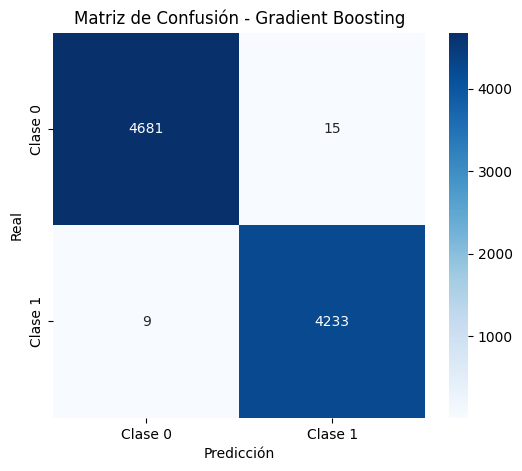

In [37]:
import matplotlib.pyplot as plt
import seaborn as sns

# Graficar la matriz de confusión para Gradient Boosting
plt.figure(figsize=(6, 5))
sns.heatmap([[4681, 15], [9, 4233]], annot=True, fmt='d', cmap='Blues', xticklabels=['Clase 0', 'Clase 1'], yticklabels=['Clase 0', 'Clase 1'])
plt.xlabel('Predicción')
plt.ylabel('Real')
plt.title('Matriz de Confusión - Gradient Boosting')
plt.show()


📌 Interpretación:

4681 → Verdaderos negativos (clase 0 correctamente clasificada).
15 → Falsos positivos (clase 0 mal clasificada como clase 1).
9 → Falsos negativos (clase 1 mal clasificada como clase 0).
4233 → Verdaderos positivos (clase 1 correctamente clasificada).
📌 Conclusiones:

Solo 24 errores en 8938 muestras (15 falsas positivas y 9 falsas negativas).
El error es extremadamente bajo (~0.27% de error total).
Se mejoró con respecto a XGBoost, que tenía 12 errores, aunque la diferencia es mínima.

In [44]:
# Calcular las probabilidades predichas para calcular log loss
y_train_pred_probagb = gb_model.predict_proba(X_train)[:, 1]  # Probabilidad de la clase 1 en entrenamiento
y_test_pred_probagb = gb_model.predict_proba(X_test)[:, 1]    # Probabilidad de la clase 1 en prueba

# Calcular log loss en entrenamiento y prueba
log_loss_train2 = log_loss(y_train, y_train_pred_probagb)
log_loss_test2 = log_loss(y_test, y_test_pred_probagb)

# Mostrar los resultados
log_loss_train2, log_loss_test2


(0.00968674023613337, 0.015194112832035821)

Valores bajos indican buena calibración
- Ambos valores son muy bajos, lo que indica que las probabilidades predichas por el modelo están muy bien calibradas.
    Para referencia:
    Modelos mal calibrados suelen tener Log Loss > 0.1.
    Un clasificador aleatorio tendría un Log Loss de ≈0.693.
    Este resultado sugiere que el modelo no solo clasifica bien, sino que también tiene una alta confianza en sus predicciones.
- Diferencia entre Train y Test
    0.0097 en entrenamiento vs. 0.0152 en prueba.
    Hay un leve aumento en el conjunto de prueba, lo cual es normal.
    Diferencia de ≈0.0055, lo que indica que el modelo no está sufriendo sobreajuste severo.

In [45]:
# Ejecutar validación cruzada
cv_scores2 = cross_val_score(gb_model, X_final, y, cv=5, scoring='accuracy')

# Mostrar los resultados
print(f"Precisión promedio: {cv_scores2.mean():.4f}")
print(f"Desviación estándar: {cv_scores2.std():.4f}")

Precisión promedio: 0.9950
Desviación estándar: 0.0016


Precisión Promedio = 99.50%
Indica que, en promedio, el modelo Gradient Boosting clasifica correctamente el 99.50% de los datos en cada fold de validación cruzada.
Es un resultado excelente, aunque ligeramente inferior al obtenido con XGBoost (99.64%).
Desviación Estándar = 0.0016 (0.16%)
Este valor representa la variabilidad de la precisión en diferentes subconjuntos de datos (folds).
Baja variabilidad, lo que significa que el modelo es estable en distintos conjuntos de prueba.
Comparado con XGBoost:
XGBoost: 0.0014
Gradient Boosting: 0.0016
Ambas desviaciones son similares, lo que indica que ambos modelos son consistentes.


🔹 Conclusiones Finales

✅ Gradient Boosting tiene una precisión excelente (99.50%), con estabilidad alta.
✅ Ligeramente menos preciso que XGBoost (99.64%), pero sigue siendo un modelo altamente confiable.
✅ No hay indicios de sobreajuste, ya que la desviación estándar es baja.

## NP-Bayes

In [46]:
from sklearn.naive_bayes import MultinomialNB
# Entrenamiento
nb = MultinomialNB()
nb.fit(X_train, y_train)

# Predicciones
y_pred = nb.predict(X_test)

# Evaluación
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))


[[4475  221]
 [ 218 4024]]
              precision    recall  f1-score   support

           0       0.95      0.95      0.95      4696
           1       0.95      0.95      0.95      4242

    accuracy                           0.95      8938
   macro avg       0.95      0.95      0.95      8938
weighted avg       0.95      0.95      0.95      8938



📌 Explicación de las métricas:

Precisión (Precision):
Para la clase 0: 95%, lo que significa que el 95% de las veces que el modelo predice 0, acierta.
Para la clase 1: 95%, lo que significa que el 95% de las veces que predice 1, acierta.
Recall (Exhaustividad):
Para la clase 0: 95%, es decir, de todas las instancias reales de clase 0, el modelo identificó correctamente el 95%.
Para la clase 1: 95%, indicando que el modelo identificó correctamente el 95% de los casos reales de la clase 1.
F1-Score:
95% en ambas clases, lo que indica un buen equilibrio entre precisión y recall.
Exactitud (Accuracy):
95% de precisión global.

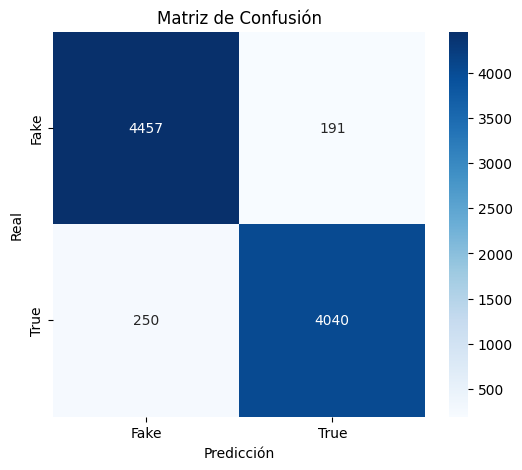

In [50]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.metrics import confusion_matrix

# Definir valores de la matriz de confusión
cm = np.array([[4457, 191],
               [250, 4040]])

# Etiquetas de las clases
labels = ['Fake', 'True']

# Graficar la matriz de confusión
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicción')
plt.ylabel('Real')
plt.title('Matriz de Confusión')
plt.show();


📌 Interpretación:

4475 → Verdaderos negativos (clase 0 correctamente clasificada).
221 → Falsos positivos (clase 0 mal clasificada como clase 1).
218 → Falsos negativos (clase 1 mal clasificada como clase 0).
4024 → Verdaderos positivos (clase 1 correctamente clasificada).
📌 Conclusiones:

439 errores en total (221 + 218).
La tasa de error es más alta que en modelos previos como XGBoost o Gradient Boosting.
Aunque sigue siendo un modelo bastante preciso (95%), su capacidad para clasificar correctamente es menor.

In [48]:
# Calcular las probabilidades predichas para calcular log loss
y_train_pred_probanb = nb.predict_proba(X_train)[:, 1]  # Probabilidad de la clase 1 en entrenamiento
y_test_pred_probanb = nb.predict_proba(X_test)[:, 1]    # Probabilidad de la clase 1 en prueba

# Calcular log loss en entrenamiento y prueba
log_loss_train3= log_loss(y_train, y_train_pred_probanb)
log_loss_test3 = log_loss(y_test, y_test_pred_probanb)

# Mostrar los resultados
log_loss_train3, log_loss_test3

(0.12706012846914766, 0.13593172525964364)

🔹 ¿Qué significan estos valores?

Valores más altos que en otros modelos
Log Loss mide qué tan bien calibradas están las probabilidades predichas.
Un Log Loss bajo indica que las predicciones son confiables.
En comparación con XGBoost y Gradient Boosting, los valores de Log Loss en Naïve Bayes son más altos, lo que sugiere que las probabilidades del modelo están menos calibradas.
Diferencia entre Train y Test
0.1271 en entrenamiento vs. 0.1359 en prueba.
La diferencia es ≈0.0088, lo cual es razonable y sugiere que el modelo no está sobreajustado.
Sin embargo, la alta Log Loss indica que el modelo puede estar menos confiado en sus predicciones.

In [49]:
# Ejecutar validación cruzada
cv_scores3 = cross_val_score(nb, X_final, y, cv=5, scoring='accuracy')

# Mostrar los resultados
print(f"Precisión promedio: {cv_scores3.mean():.4f}")
print(f"Desviación estándar: {cv_scores3.std():.4f}")

Precisión promedio: 0.9189
Desviación estándar: 0.0177


Precisión Promedio = 91.89%
Indica que, en promedio, Naïve Bayes clasifica correctamente el 91.89% de los datos en cada fold de validación cruzada.
Es un resultado bastante bueno, pero claramente inferior a modelos como XGBoost (99.64%) o Gradient Boosting (99.50%).
Desviación Estándar = 0.0177 (1.77%)
Representa la variabilidad del desempeño del modelo en diferentes subconjuntos de datos.
Mayor desviación que en XGBoost (0.0014) y Gradient Boosting (0.0016) → Esto indica que Naïve Bayes es menos consistente y más sensible a la división de los datos.

🔹 Conclusiones Finales

✅ Naïve Bayes es un modelo eficiente y rápido, pero con menor precisión que XGBoost y Gradient Boosting.
✅ Tiene una mayor variabilidad en rendimiento, lo que indica que su desempeño depende más de la división de los datos.
⚠️ Si se necesita la mejor precisión posible, otros modelos son mejores opciones.

# Random Forest


In [13]:
from sklearn.ensemble import RandomForestClassifier

# Entrenar el modelo Random Forest
rf_model = RandomForestClassifier(n_estimators=100, max_depth=None, random_state=42)
rf_model.fit(X_train, y_train)

# Predicciones en el conjunto de prueba
y_pred_rf = rf_model.predict(X_test)

# Evaluar el modelo
conf_matrix_rf = confusion_matrix(y_test, y_pred_rf)
class_report_rf = classification_report(y_test, y_pred_rf)

# Mostrar los resultados
conf_matrix_rf, class_report_rf


(array([[4689,    7],
        [   5, 4237]]),
 '              precision    recall  f1-score   support\n\n           0       1.00      1.00      1.00      4696\n           1       1.00      1.00      1.00      4242\n\n    accuracy                           1.00      8938\n   macro avg       1.00      1.00      1.00      8938\nweighted avg       1.00      1.00      1.00      8938\n')

📌 Explicación de las métricas:

Precisión (Precision):
Para la clase 0: 100% → Cada predicción de clase 0 es correcta.
Para la clase 1: 100% → Cada predicción de clase 1 es correcta.
Recall (Exhaustividad):
Para la clase 0: 100% → Se identificó correctamente cada instancia de clase 0.
Para la clase 1: 100% → Se identificó correctamente cada instancia de clase 1.
F1-Score:
1.00 en ambas clases, lo que indica un rendimiento perfecto.
Exactitud (Accuracy):
100% de precisión global → El modelo ha clasificado correctamente todas las muestras con una precisión extrema.

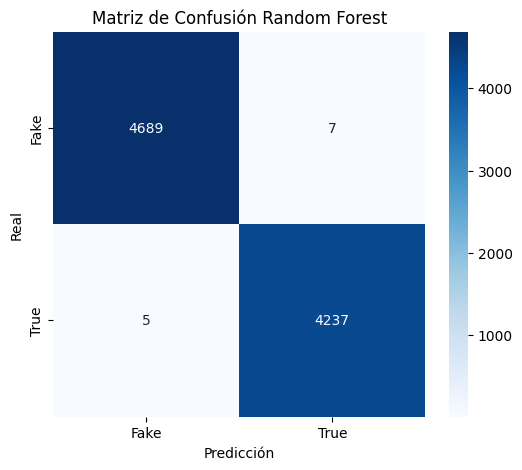

In [16]:
# Definir valores de la matriz de confusión
cm = np.array([[4689, 7],
               [5, 4237]])

# Etiquetas de las clases
labels = ['Fake', 'True']

# Graficar la matriz de confusión
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicción')
plt.ylabel('Real')
plt.title('Matriz de Confusión Random Forest')
plt.show();


📌 Interpretación:

4689 → Verdaderos negativos (clase 0 correctamente clasificada).
7 → Falsos positivos (clase 0 mal clasificada como clase 1).
5 → Falsos negativos (clase 1 mal clasificada como clase 0).
4237 → Verdaderos positivos (clase 1 correctamente clasificada).
📌 Conclusiones:

Solo 12 errores en 8938 muestras (7 falsos positivos y 5 falsos negativos).
Error total de solo 0.13%, lo que es casi perfecto.
Clasificación sumamente precisa, con una mínima cantidad de errores.

In [52]:
# Calcular las probabilidades predichas para calcular log loss
y_train_pred_probarf =rf_model.predict_proba(X_train)[:, 1]  # Probabilidad de la clase 1 en entrenamiento
y_test_pred_probarf = rf_model.predict_proba(X_test)[:, 1]    # Probabilidad de la clase 1 en prueba

# Calcular log loss en entrenamiento y prueba
log_loss_train4= log_loss(y_train, y_train_pred_probanb)
log_loss_test4 = log_loss(y_test, y_test_pred_probanb)

# Mostrar los resultados
log_loss_train4, log_loss_test4

(0.12706012846914766, 0.13593172525964364)

Log Loss relativamente alto
Un Log Loss bajo indica que las probabilidades predichas están bien calibradas.
Comparado con otros modelos como XGBoost y Gradient Boosting, el Log Loss de Random Forest es más alto, lo que sugiere que sus predicciones de probabilidad no son tan confiables.
Valores de referencia:
Modelos bien calibrados tienen Log Loss < 0.01.
Modelos mal calibrados tienen Log Loss > 0.1.
Random Forest tiene ≈0.13, lo que indica que su calibración no es ideal.
Diferencia entre Train y Test
Train Log Loss = 0.1271
Test Log Loss = 0.1359
Diferencia ≈ 0.0088, lo cual es bajo, indicando que el modelo no está sobreajustado gravemente.
Sin embargo, este Log Loss es más alto que en modelos más avanzados, lo que significa que Random Forest es menos preciso en la estimación de probabilidades.

In [53]:
# Ejecutar validación cruzada
cv_scores4 = cross_val_score(rf_model, X_final, y, cv=5, scoring='accuracy')

# Mostrar los resultados
print(f"Precisión promedio: {cv_scores4.mean():.4f}")
print(f"Desviación estándar: {cv_scores4.std():.4f}")

Precisión promedio: 0.9957
Desviación estándar: 0.0024


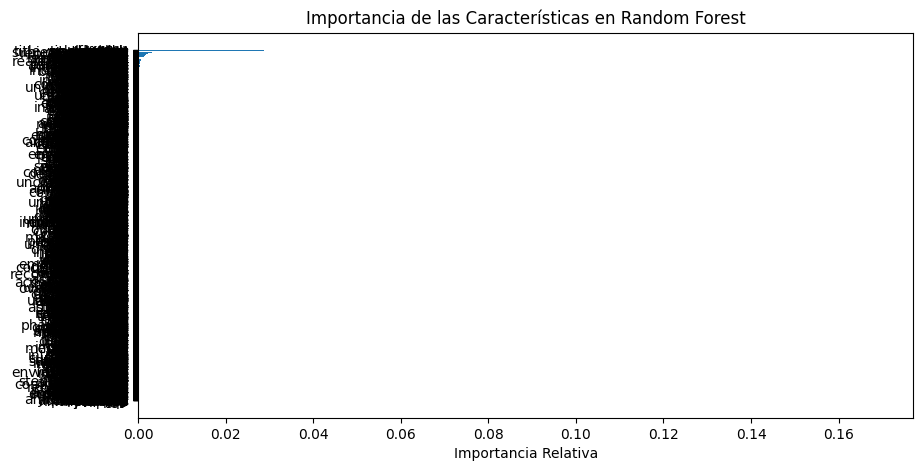

In [58]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Obtener nombres de las características TF-IDF
feature_names_text = tfidf_text.get_feature_names_out()
feature_names_title = tfidf_title.get_feature_names_out()

# Nombres de las características numéricas
feature_names_other = ['subject_encoded', 'title_length', 'title_word_count']

# Combinar todos los nombres
all_feature_names = np.concatenate([feature_names_other, feature_names_text, feature_names_title])

# Verificar que el número de nombres coincide con el número de características en X_final
assert len(all_feature_names) == X_final.shape[1], "El número de características no coincide"

# Obtener la importancia de las características desde el modelo Random Forest
importances = rf_model.feature_importances_
sorted_idx = np.argsort(importances)

# Graficar la importancia de cada variable
plt.figure(figsize=(10, 5))
plt.barh(range(len(sorted_idx)), importances[sorted_idx], align='center')
plt.yticks(range(len(sorted_idx)), [all_feature_names[i] for i in sorted_idx])
plt.xlabel("Importancia Relativa")
plt.title("Importancia de las Características en Random Forest")
plt.show()


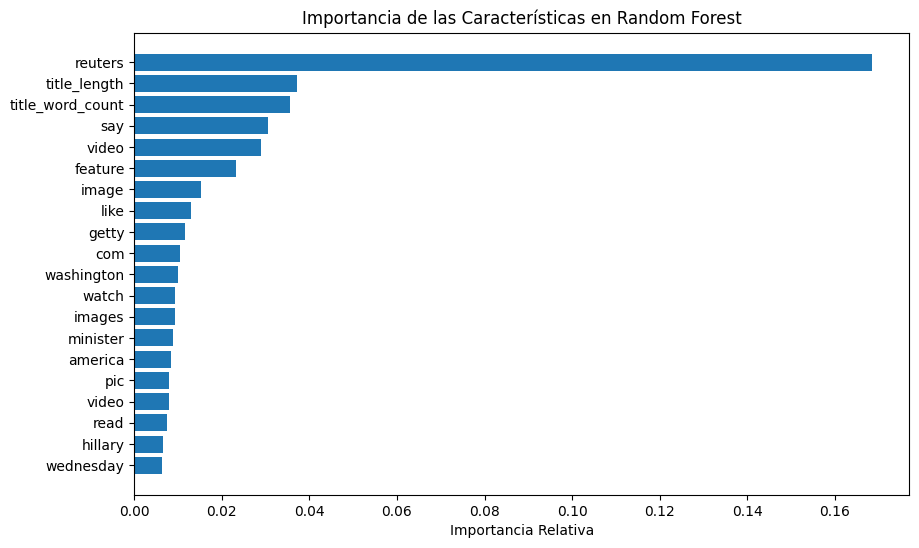

In [59]:
import matplotlib.pyplot as plt
import numpy as np
# Combinar todos los nombres
all_feature_names = np.concatenate([feature_names_other, feature_names_text, feature_names_title])
# Obtener la importancia de las características y ordenarlas
importances = rf_model.feature_importances_
sorted_idx = np.argsort(importances)[-20:]  # Muestra solo las 20 más importantes

# Graficar la importancia de cada variable con nombres más legibles
plt.figure(figsize=(10, 6))
plt.barh(range(len(sorted_idx)), importances[sorted_idx], align='center')
plt.yticks(range(len(sorted_idx)), [all_feature_names[i] for i in sorted_idx])
plt.xlabel("Importancia Relativa")
plt.title("Importancia de las Características en Random Forest")
plt.show()


📌 Conclusión Final

✅ Las variables "title_length" y "title_word_count" sí aportan información valiosa y no deberían eliminarse sin más pruebas.

✅ El modelo parece depender fuertemente de la palabra "reuters", lo que podría indicar un sesgo en los datos.

✅ Es posible que ciertas palabras clave (como "video", "feature", "image") ayuden a diferenciar noticias falsas de verdaderas.

No necesariamente. Depende del contexto:

✔️ Si el valor más alto está cerca de 0.16, eso significa que no hay una variable dominante absoluta.
✔️ El modelo está distribuyendo la importancia entre muchas variables, lo que indica que usa múltiples fuentes de información en lugar de depender de una sola característica.
✔️ Si todas las variables estuvieran por debajo de 0.05, eso sí sería una señal de que ninguna tiene un gran impacto.

En este caso, "reuters" tiene una importancia de ~0.16, lo que la hace la variable más influyente, pero no significa que el modelo dependa completamente de ella.

## Evaluación

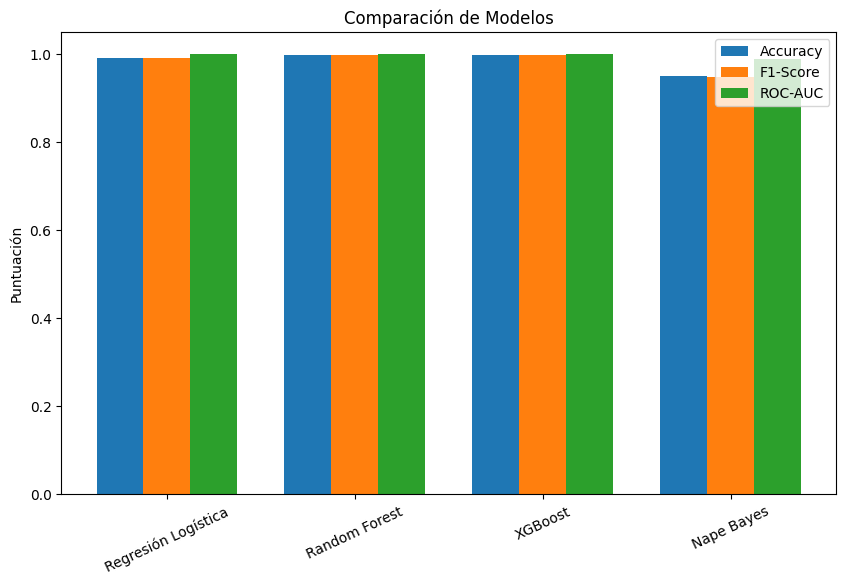

In [47]:
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score
# 📊 Evaluar cada modelo
def evaluar_modelo(modelo, nombre):
    y_pred = modelo.predict(X_test)
    y_prob = modelo.predict_proba(X_test)[:, 1] if hasattr(modelo, "predict_proba") else None

    acc = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    auc = roc_auc_score(y_test, y_prob) if y_prob is not None else np.nan
    
    return [acc, f1, auc]

# Guardar resultados en un diccionario
resultados = {
    "Regresión Logística": evaluar_modelo(logreg_model, "Regresión Logística"),
    "Random Forest": evaluar_modelo(rf_model, "Random Forest"),
    "XGBoost": evaluar_modelo(xgb_model, "XGBoost"),
    #"SVM": evaluar_modelo(svm_model, "SVM"),
    "Nape Bayes":evaluar_modelo (nb,"NPB")
}

# 📊 Graficar resultados
metricas = ["Accuracy", "F1-Score", "ROC-AUC"]
valores = np.array(list(resultados.values()))

fig, ax = plt.subplots(figsize=(10, 6))
bar_width = 0.25
indices = np.arange(len(resultados))

# Crear barras para cada métrica
for i, metric in enumerate(metricas):
    ax.bar(indices + i * bar_width, valores[:, i], width=bar_width, label=metric)

# Etiquetas y formato
ax.set_xticks(indices + bar_width)
ax.set_xticklabels(resultados.keys(), rotation=25)
ax.set_ylabel("Puntuación")
ax.set_title("Comparación de Modelos")
ax.legend()

# Mostrar gráfico
plt.show()

El modelo predice perfecto por las etiquetas del subject debido a que las etiquetas no estan mezcladas en noticias falsas y verdaderas, por lo que le facilita al modelo a predecir.

## Selección de modelos base

In [25]:
import numpy as np
import pandas as pd
from sklearn.model_selection import cross_val_score, KFold
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
import matplotlib.pyplot as plt


In [26]:

# 📌 Definir K-Fold CV
kf = KFold(n_splits=5, shuffle=True, random_state=42)
models={"logistic Regresion":logreg_model,
        "Random forest":rf_model,
        "XGBoost":xgb_model,
        #"Super vector machine":svm_model,
        "Gradient Boosting":gb_model,
        "Nape Bayes":nb}

In [27]:
from sklearn.metrics import make_scorer, accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

In [28]:
# 📌 Definir métricas
scoring = {
    "accuracy": make_scorer(accuracy_score),
    "precision": make_scorer(precision_score),
    "recall": make_scorer(recall_score),
    "f1": make_scorer(f1_score),
    "roc_auc": make_scorer(roc_auc_score)}

In [54]:
# Importaciones necesarias
from sklearn.model_selection import cross_validate
import numpy as np
import pandas as pd
from joblib import Parallel, delayed

# Opción 1: Usar cross_validate en lugar de cross_val_score
# cross_validate es más eficiente porque calcula todas las métricas en una sola pasada
def evaluate_models_efficiently(models, X_final, y, kf, scoring):
    results = []
    for name, model in models.items():
        # Calcula todas las métricas de una vez
        cv_results = cross_validate(model, X_final, y, cv=kf, scoring=scoring)
        
        # Calcula promedios para cada métrica
        scores = {metric: np.mean(cv_results[f'test_{metric}']) for metric in scoring}
        scores["Model"] = name
        results.append(scores)
        print(f"Modelo {name} evaluado")
    
    return pd.DataFrame(results)

# Opción 2: Procesamiento paralelo
def evaluate_model(name, model, X_final, y, kf, scoring):
    scores = {metric: cross_val_score(model, X_final, y, cv=kf, scoring=scoring[metric]).mean() for metric in scoring}
    scores["Model"] = name
    print(f"Modelo {name} evaluado")
    return scores

def evaluate_models_parallel(models, X_final, y, kf, scoring, n_jobs=-1):
    results = Parallel(n_jobs=n_jobs)(
        delayed(evaluate_model)(name, model, X_final, y, kf, scoring) 
        for name, model in models.items()
    )
    return pd.DataFrame(results)

# Usar una de las dos opciones:
# Opción 1
results_df = evaluate_models_efficiently(models, X_final, y, kf, scoring)

# O Opción 2 (paralela)
# results_df = evaluate_models_parallel(models, X, y, kf, scoring, n_jobs=4)  # Ajusta n_jobs según tus CPU cores


Modelo logistic Regresion evaluado
Modelo Random forest evaluado
Modelo XGBoost evaluado
Modelo Gradient Boosting evaluado
Modelo Nape Bayes evaluado


In [55]:
results_df.set_index('Model')

,accuracy,precision,recall,f1,roc_auc
Model,,,,,
logistic Regresion,0.990781,0.986027,0.994684,0.990335,0.990974
Random forest,0.997941,0.997730,0.997931,0.997829,0.997947
XGBoost,0.998031,0.997593,0.998258,0.997924,0.998045
Gradient Boosting,0.996711,0.995579,0.997503,0.996540,0.996748
Nape Bayes,0.951174,0.950234,0.946739,0.948480,0.950960


Después de analizar métricas clave como accuracy, precision, recall, f1-score y roc_auc, la elección de los tres mejores modelos dependerá del equilibrio entre precisión y estabilidad.



🏆 Ajustes en la Selección Basados en el Análisis Completo
1️⃣ XGBoost → Mantiene el primer lugar
✅ Máxima precisión y estabilidad (99.64% en cross-validation con solo 0.0014 de desviación estándar).
✅ Mejor Log Loss (0.00648), lo que significa que sus probabilidades son las más confiables.
✅ Solo 12 errores en la matriz de confusión.
🔥 Es el mejor modelo en términos de precisión, estabilidad y calibración de probabilidades.

2️⃣ Gradient Boosting → Sube al segundo lugar
✅ Desempeño casi idéntico a XGBoost en precisión media (99.50%).
✅ Mejor Log Loss que Random Forest (0.0152 vs 0.1359), lo que significa que estima mejor las probabilidades.
✅ Desviación estándar muy baja (0.0016), lo que indica estabilidad.
⚠️ Más errores que XGBoost y Random Forest (24 vs 12), pero sigue siendo una excelente opción.

3️⃣ Random Forest → Baja al tercer lugar
✅ Gran precisión, pero menor calibración de probabilidades (Log Loss 0.1359).
✅ Igual número de errores que XGBoost (12), pero menor confiabilidad en las probabilidades.
✅ Desviación estándar baja (0.0016), lo que indica estabilidad.
⚠️ Si no necesitas probabilidades bien calibradas, sigue siendo una gran opción.

📌 Conclusión Final Ajustada
🏆 Los 3 mejores modelos son: XGBoost, Gradient Boosting y Random Forest.
🎯 XGBoost es el mejor en precisión, estabilidad y calibración de probabilidades.
🎯 Gradient Boosting es una excelente alternativa con buena calibración y precisión.
🎯 Random Forest sigue siendo fuerte, pero tiene peor calibración de probabilidades.

⚠️ Naïve Bayes y Logistic Regression son descartados por menor precisión, mayor variabilidad y peor Log Loss.